Copyright (c) MONAI Consortium<br>
Licensed under the Apache License, Version 2.0 (the "License");<br>
you may not use this file except in compliance with the License.<br>
You may obtain a copy of the License at<br>
    http://www.apache.org/licenses/LICENSE-2.0<br>
Unless required by applicable law or agreed to in writing, software<br>
distributed under the License is distributed on an "AS IS" BASIS,<br>
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.<br>
See the License for the specific language governing permissions and<br>
limitations under the License.<br>

# AutoencoderKL

This demo is a toy example of how to use MONAI's `AutoencoderKL` class. In particular, it uses
the Autoencoder with a Kullback-Leibler regularisation as implemented by Rombach et. al [1]. The autoencoder was originally implemented by Kingma et al. [2]. 

[1] Rombach et. al "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/pdf/2112.10752.pdf<br>
[2] Kingma, D. P., & Welling, M. (2014). Auto-Encoding Variational Bayes. CoRR, abs/1312.6.



This tutorial was based on:

[Registration Mednist](https://github.com/Project-MONAI/tutorials/blob/main/2d_registration/registration_mednist.ipynb)

[Mednist Tutorial](https://github.com/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb)




## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [ ]:
import os
import shutil
import time
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch.nn import L1Loss
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.utils.misc import ensure_tuple

print_config()

## Setup a data directory

Specify a `MONAI_DATA_DIRECTORY` variable, where the data will be downloaded. If not
specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp84mwb3ce


## Set deterministic training for reproducibility

In [2]:
set_determinism(42)

## Description of data and download the training set

We used the "hand" category in the MedNIST dataset.

In [4]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)

MedNIST.tar.gz: 59.0MB [00:01, 43.8MB/s]                                                                                                                                                                                                                                                                   

2024-09-05 17:32:06,408 - INFO - Downloaded: /tmp/tmp84mwb3ce/MedNIST.tar.gz


2024-09-05 17:32:06,500 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-05 17:32:06,501 - INFO - Writing into directory: /tmp/tmp84mwb3ce.


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:16<00:00, 2897.60it/s]


2024-09-05 17:32:27,771 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-05 17:32:27,771 - INFO - File exists: /tmp/tmp84mwb3ce/MedNIST.tar.gz, skipped downloading.
2024-09-05 17:32:27,771 - INFO - Non-empty folder exists in /tmp/tmp84mwb3ce/MedNIST, skipped extracting.


Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:01<00:00, 2972.78it/s]


## Prepare dataloaders

In [5]:
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]

We apply the following transforms:
1. `LoadImaged`: to load the images
2. `EnsureChannelFirst`: to make sure a channel is added on the first dimension
3. `ScaleIntensityRanged`: scale intensity between 0 and 1
4. `RandAffined`: we apply random affine transformations, including rotations, translations and scaling to augment the dataset

On validation, we do not augment.

In [6]:
image_size = 64
all_transforms = [
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    transforms.RandAffined(
        keys=["image"],
        rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
        translate_range=[(-1, 1), (-1, 1)],
        scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
        spatial_size=[image_size, image_size],
        padding_mode="zeros",
        prob=0.5,
    ),
]

Define datasets and dataloaders:

In [7]:
train_ds = Dataset(data=train_datalist, transform=transforms.Compose(all_transforms))
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, persistent_workers=True)
val_ds = Dataset(data=val_datalist, transform=transforms.Compose(all_transforms[:-1]))
val_loader = DataLoader(val_ds, batch_size=8, shuffle=True, num_workers=2, persistent_workers=True)

### Visualise examples from the training set

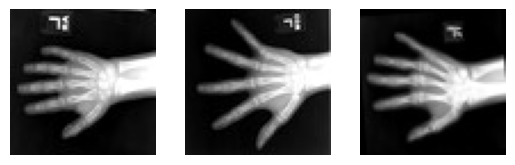

In [8]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

## Define the network

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [ ]:
model = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(128, 256, 384),
    latent_channels=8,
    num_res_blocks=1,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
model.to(device)

In [ ]:
discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    channels=64,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)

## Network losses

Kingma et al. [2] trained the autoencoder on a reconstruction (L1 or L2 loss) and a Kullback-Leibler loss comparing the latent representation to a Normal distribution. In [1], Rombach et al. add perceptual and aversarial losses to improve the reconstruction quality.

In [ ]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)

In [13]:
optimizer_g = torch.optim.Adam(params=model.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=5e-4)

In [15]:
l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01
perceptual_weight = 0.001

## Model Training

In [17]:
kl_weight = 1e-6
max_epochs = 100
print_every = 10
val_interval = 25
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)
        reconstruction, z_mu, z_sigma = model(images)
        recons_loss = l1_loss(reconstruction.float(), images.float())
        kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
        kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
        logits_fake = discriminator(reconstruction.contiguous().float())[-1]
        p_loss = perceptual_loss(reconstruction.float(), images.float())
        generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
        loss_g = recons_loss + kl_weight * kl_loss + perceptual_weight * p_loss + adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()

        # Discriminator part
        optimizer_d.zero_grad(set_to_none=True)

        logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
        loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
        logits_real = discriminator(images.contiguous().detach())[-1]
        loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
        discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

        loss_d = adv_weight * discriminator_loss

        loss_d.backward()
        optimizer_d.step()

        epoch_loss += recons_loss.item()
        gen_epoch_loss += generator_loss.item()
        disc_epoch_loss += discriminator_loss.item()

    epoch_recon_loss_list.append(epoch_loss / len(train_loader))
    epoch_gen_loss_list.append(gen_epoch_loss / len(train_loader))
    epoch_disc_loss_list.append(disc_epoch_loss / len(train_loader))

    if epoch % print_every == 0:
        msgs = [
            f"epoch {epoch:d}/{max_epochs:d}:",
            f"recons loss: {epoch_recon_loss_list[-1]:4f},"
            f"gen_loss: {epoch_gen_loss_list[-1]:4f},"
            f"disc_loss: {epoch_disc_loss_list[-1]:4f}",
        ]
        print("".join(msgs))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader):
                images = batch["image"].to(device)
                reconstruction, _, _ = model(images)

                # get the first sammple from the first validation batch for visualisation
                # purposes
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                recons_loss = l1_loss(reconstruction.float(), images.float())

                val_loss += recons_loss.item()

        val_loss /= len(val_loader)
        val_recon_epoch_loss_list.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

epoch 0/100:recons loss: 0.023390,gen_loss: 0.292826,disc_loss: 0.244051
epoch 10/100:recons loss: 0.019977,gen_loss: 0.293877,disc_loss: 0.246095
epoch 20/100:recons loss: 0.017823,gen_loss: 0.290595,disc_loss: 0.242387
epoch 30/100:recons loss: 0.016301,gen_loss: 0.300653,disc_loss: 0.239462
epoch 40/100:recons loss: 0.016317,gen_loss: 0.324037,disc_loss: 0.241039
epoch 50/100:recons loss: 0.014776,gen_loss: 0.304615,disc_loss: 0.231920
epoch 60/100:recons loss: 0.015453,gen_loss: 0.371261,disc_loss: 0.216630
epoch 70/100:recons loss: 0.015820,gen_loss: 0.381722,disc_loss: 0.214916
epoch 80/100:recons loss: 0.015885,gen_loss: 0.387530,disc_loss: 0.217283
epoch 90/100:recons loss: 0.015494,gen_loss: 0.402209,disc_loss: 0.207687
train completed, total time: 5108.975979089737.


## Evaluate the training
### Visualise the loss

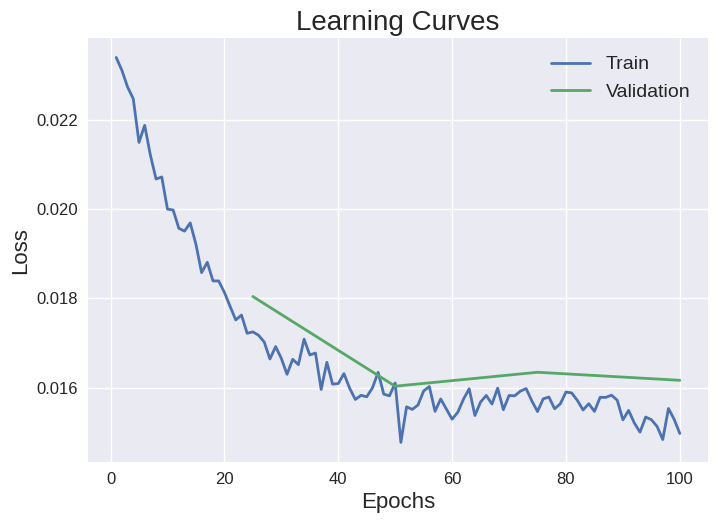

In [22]:
plt.style.use("seaborn-v0_8")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_recon_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, max_epochs, int(max_epochs / val_interval)),
    val_recon_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

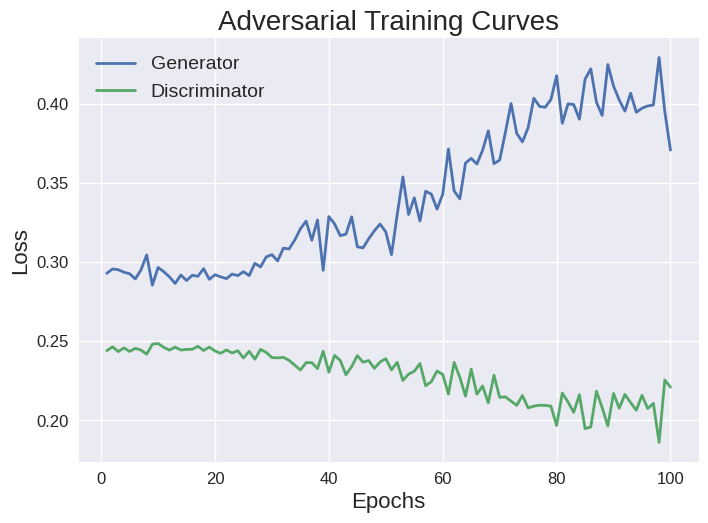

In [23]:
# %%
plt.title("Adversarial Training Curves", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_gen_loss_list, color="C0", linewidth=2.0, label="Generator")
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_disc_loss_list, color="C1", linewidth=2.0, label="Discriminator")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Visualise some reconstruction images

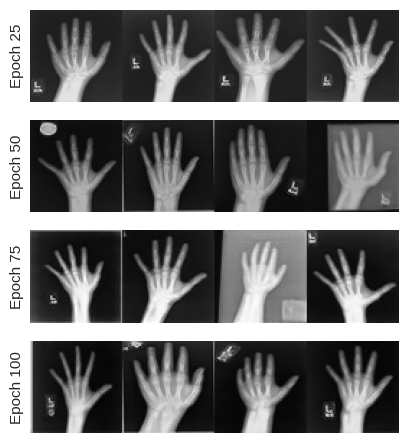

In [25]:
# Plot every evaluation as a new line and example as columns
val_samples = np.linspace(val_interval, max_epochs, int(max_epochs / val_interval))
fig, ax = plt.subplots(nrows=len(val_samples), ncols=1, sharey=True)
ax = ensure_tuple(ax)
for image_n in range(len(val_samples)):
    reconstructions = torch.reshape(intermediary_images[image_n], (64 * n_example_images, 64)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

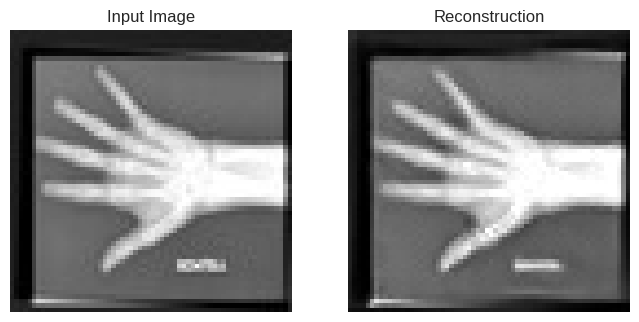

In [26]:
# %%
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(images[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Input Image")
ax[1].imshow(reconstruction[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)